<a href="https://colab.research.google.com/github/CarlosSMWolff/Photon-Bundles/blob/main/0-Experimental-proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emission of $N$-photon bundles in cQED

## **README:** How to use this notebook

This notebook is a plug-and-play tool to understand the feasibility of the experiment. Setting the parametes, the code provides the emission spectrum (the quantity to measure) and other important additional quantities that can corroborate the results. The notebook already takes into account several facts (e.g., the fact that the transmon is not a perfect qubit), and it contains several check checks to verify that the calculations are consistant.


Related papers:

In this notebook we preset the basic quantities showing the presence of n-photon-bundle emission in superconducting architectures consisting of one cavity and one strongly-driven qubit. A more in-depth review is in:?

[Emitters of N-photon bundles (Nature Photonics)](https://www.nature.com/articles/nphoton.2014.114)


[Filtering multiphoton emission from state-of-the-art cavity quantum electrodynamics (Optica)](https://opg.optica.org/optica/fulltext.cfm?uri=optica-5-1-14&id=380596)

![Paper](https://carlossanchezmunoz.weebly.com/uploads/1/3/2/3/132365119/transitions_2.png)

We consider the following Hamiltonian:

$$ \hat H = (\omega_q+\Delta_a)  \hat a^\dagger \hat a + \omega_q \hat b ^\dagger \hat b 
+ U \hat b^\dagger \hat b^\dagger \hat b \hat b + g(\hat a^\dagger \hat b + \hat a \hat b^\dagger )  + \Omega_q \cos(\omega_q t) (\hat b + \hat b^\dagger)$$
The mode $\hat a$ is the linear cavity, $\hat b$ is a transmon. $U$ is the Kerr nonlinearity, $\omega_q$ is the qubit frequency, $\Delta_a$ is the difference in frequency between the mode $a$ and $b$
The mode $\hat b$ is driven at an amplitude $\Omega_q$ and at resonance. Thus, in the rotating frame of a coherent drive
$$ \hat H = \Delta_a \hat a^\dagger \hat a
+ U \hat b^\dagger \hat b^\dagger \hat b \hat b + g(\hat a^\dagger \hat b + \hat a \hat b^\dagger )  + \Omega_q(\hat b + \hat b^\dagger)$$


We assume:


1.  Qubit described by Kerr cavity
2.   Jaynes-Cummings interaction



Notice that, in the bundling regime, the following relations must hold:

$$ g \ll \Delta_a=\Omega_q \ll U  $$

Explanation:



1.   $g \ll \Delta_a$ is required so that first-order qubit-atom coupling effects are well out of resonance. This way we are sure that **only photon pairs are exchanged** between cavity and dressed qubit at the two-photon resonance $\Omega_q=\Delta_a$.
2.   $ \Omega_q \ll U  $ is required to keep the two-level system approximation. This condition could be relaxed, but the results become more complicated to interpret. 



In [ ]:
# Parameters 

U = -200 #MHz
g = 10 #MHz

kappa = 3 #MHz
gamma_phi = 1 #MHz
gamma_q = 0.1 #MHz

Delta_a = 10*g
Delta_q = 0 # MHz

For numerical reasons, we fix here the cutoff in the Hilbert space of the cavity and of the qubit. Check the validity of the results at the end of the notebook.

In [ ]:
Ncav = 4     # Truncation number in the cavity 
Nqubit = 5    # Trunction number in the qubit-cavity

# Hamiltonian definition and required code to set up the notebook (definition and other stuff, can be just compiled)

## Import necessary packages

In [ ]:
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  ! pip install qutip

import numpy as np
from qutip import *

from numpy import sqrt, pi
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import spsolve
if qutip.settings.has_mkl:
    from qutip._mkl.spsolve import mkl_spsolve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Definitions of Hamiltonian, Liouvillian and useful functions 

We will define a cavity with annihilation operator $\hat a$, and a qubit given by a cavity with annihilation operator $\hat b$ and a Kerr-type nonlinearity $U$.

In [ ]:
a = tensor(destroy(Ncav), qeye(Nqubit))
b = tensor(qeye(Ncav), destroy(Nqubit))

vac = tensor(basis(Ncav,0), basis(Nqubit,0))

In [ ]:
def gen_Hamiltonian(params:list):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  H = (Delta_a * a.dag()*a + Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b +
       g*(a.dag()*b + b.dag()*a) 
  + Omega_a*(a.dag()+a) + Omega_q*(b.dag()+b))
  return H

def gen_Liouv(params: list):
  H = gen_Hamiltonian(params)
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return liouvillian(H, c_ops)

def compute_spectrum_qutip(params: list, omega_grid, op):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params

  H = gen_Hamiltonian(params)
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return spectrum(H, omega_grid, c_ops, op.dag(), op)


def SpectrumNoEig(omega, liouv, a, Gamma, rhs = None):
  liouvM=liouv.data
  h2 = liouvM.shape[0] # Hilbert size ^2
  id = sp.identity(h2)

  if rhs ==None:
    rho_ss = steadystate(liouv)
    rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]
  rho_eff = spsolve(liouvM + 1j*id*omega -Gamma/2*id, rhs).reshape((h,h))

  np.real((-aM@rho_eff).trace()/pi)
  #return -np.real(np.trace(aM*rho_eff))/pi
  return np.real((-aM@rho_eff).trace()/pi)

def Spectrum(omega_list, liouv, Gamma, a):
  # Gamma is the filter linewidth
  liouvM=liouv.data
  h2 = liouv.shape[0] # Hilbert size ^2
  id = sp.identity(h2)
  rho_ss = steadystate(liouv)
  rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]

  eigen_vecs=liouv.eigenstates()
  E = np.transpose(np.reshape(
      np.array([eigen_vecs[1][i].full() for i in range(h2)]), 
      (h2,h2)))
  Einv = np.linalg.inv(E)
  EinvTr = Einv.T
  eigvals = eigen_vecs[0]
  Einvrhs=EinvTr@rhs

  Elist = E, Einvrhs, rhs, eigvals 


  spectrumgrid = np.asarray(
      [-np.real(
      (aM@(
          ((
          E@np.transpose(
              1/(eigvals - 1j*omega - Gamma/2)*EinvTr)          
          )@rhs).reshape((h,h))
          )).trace()
      )/pi for omega in omega_list] 
  )
  return spectrumgrid



def Spectrum_and_check_cutoff(omega_list, liouv, Gamma, a):
  # Gamma is the filter linewidth
  liouvM=liouv.data
  h2 = liouv.shape[0] # Hilbert size ^2
  id = sp.identity(h2)
  rho_ss = steadystate(liouv)
  
  max_a = tensor(basis(a.dims[0][0], a.dims[0][0]-1), qeye(a.dims[0][1]))
  max_b = tensor(qeye(a.dims[0][0]), basis(a.dims[0][1], a.dims[0][1]-1))

  border = [expect(rho_ss, max_a), expect(rho_ss, max_b)]
  rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]

  eigen_vecs=liouv.eigenstates()
  E = np.transpose(np.reshape(
      np.array([eigen_vecs[1][i].full() for i in range(h2)]), 
      (h2,h2)))
  Einv = np.linalg.inv(E)
  EinvTr = Einv.T
  eigvals = eigen_vecs[0]
  Einvrhs=EinvTr@rhs

  Elist = E, Einvrhs, rhs, eigvals 


  spectrumgrid = np.asarray(
      [-np.real(
      (aM@(
          ((
          E@np.transpose(
              1/(eigvals - 1j*omega - Gamma/2)*EinvTr)          
          )@rhs).reshape((h,h))
          )).trace()
      )/pi for omega in omega_list] 
  )
  return spectrumgrid, border 


def Spectrum_and_check_cutoff_qutip(params: list, omega_grid, op):
  # Gamma is the filter linewidth
  liouv = gen_Liouv(params)
  liouvM=liouv.data
  h2 = liouv.shape[0] # Hilbert size ^2
  id = sp.identity(h2)
  rho_ss = steadystate(liouv)
  
  max_a = tensor(basis(a.dims[0][0], a.dims[0][0]-1), qeye(a.dims[0][1]))
  max_b = tensor(qeye(a.dims[0][0]), basis(a.dims[0][1], a.dims[0][1]-1))

  border = [expect(rho_ss, max_a), expect(rho_ss, max_b)]
  spectrumgrid = compute_spectrum_qutip(params, omega_grid, op)
  
  return spectrumgrid, border 

## Computation here

In [ ]:
# Define range of Rabi frequencies
Omega_q_min, Omega_q_max, nOmega = 0.1, 15*g, 100
Omega_q_grid = np.linspace(Omega_q_min, Omega_q_max, nOmega)
Omega_a = 0

# Grid of frequencies for the spectrum measurement 
omega_min = -2*Omega_q_max; omega_max = -omega_min; nomega = 200
omega_grid = np.linspace(omega_min, omega_max, nomega)

# Gamma here is the frequency resolution of the filter/spectrum analyzer.
Gamma = 0.05

params_list = [[Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi] for Omega_q in Omega_q_grid]

In [ ]:
# Cut of the spectra at cavity frequency 
#output_and_check = [Spectrum_and_check_cutoff(omega_grid, gen_Liouv(params), Gamma, a) for params in tqdm(params_list)]
output_and_check = [Spectrum_and_check_cutoff_qutip(params,omega_grid,a) for params in tqdm(params_list)]


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [ ]:
spectrum_array = np.asarray([o[0] for o in output_and_check])
check = np.asarray([o[1] for o in output_and_check])


# The results

*   **Driving**: Qubit
*   **Output measured**: Cavity

Experiment: The Rabi frequency of the qubit driving $\Omega_q$ is increased and the spectrum of emission from the cavity is measured. A resonant feature should be observed when the cavity frequency is exactly between the central Mollow peak and one of the Mollow sidebands, i.e., when $\Omega_q =\Delta_a$.

$ \ $ \\

**Why desirable?** \\
Here, the signal is not covered by the coherent drive. The driving and the detection occur in different channels, and the cavity does not build up a strong coherent population, but only the fully quantum signal made up of photon pairs.

$ \ $ \\

**What should you do?** \\
Pump the qubit resonantly (fix the frequency of the drive), and scan the power intensity of the pump: our expected feature should be found at the point where the rescaled intensity of the pump (the Rabi frequency $\Omega_q$) matches the detuning between the pump and the cavity. 

In particular, if one calls $P$ the incoming power and $\kappa_{\text{ext}}$ the coupling to the incoming feedline, the Rabi frequency is $\Omega_q = P * \kappa_{\text{ext}}/2$.


<p align="center">
  <img src="https://drive.google.com/uc?id=1lnL7JpQ93IjR8YmQKFQoyTWfR-GpYGWd" width="500"/>
</p>


## First: numerical check

This is a check in the cutoff. If the blue line reaches $10^{-2}$, increase the cutoff of Ncav above. Same goes for the orange line, but in this case change Nqubit.

(0.0001, 0.01)

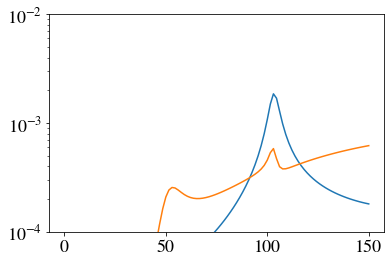

In [ ]:
plt.plot(Omega_q_grid, [abs(cc[0]) for cc in check])
plt.plot(Omega_q_grid, [abs(cc[1]) for cc in check])
plt.yscale('log')

plt.ylim(0.0001,0.01)


## The important plot: the emission spectrum

Here we plot the smoking gun of the bundled emission, i.e., the emission spectrum. 

In [ ]:
idx_cav = np.argmin(np.abs(omega_grid - Delta_a))
spectrum_at_cavity = spectrum_array[:,idx_cav]

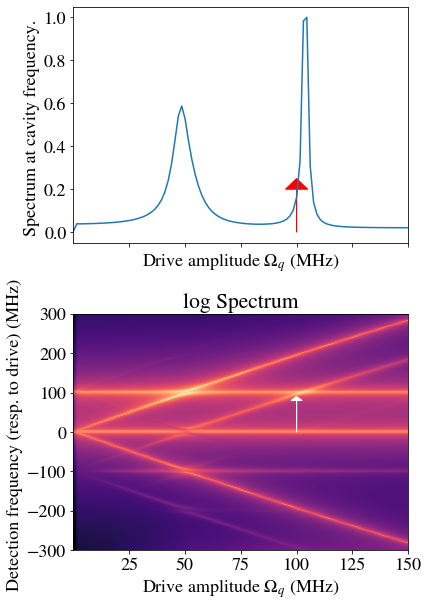

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (6,10),nrows = 2, sharex=True)

ax = ax1
ax.plot(Omega_q_grid, spectrum_at_cavity/np.max(spectrum_at_cavity))
ax.set_ylabel('Spectrum at cavity frequency. ')
ax.set_xlabel('Drive amplitude $\Omega_q$ (MHz)')

ax.arrow(Delta_a, 0, 0, 0.2, width=0.01, head_width=10, head_length=0.05, color='red')

ax = ax2
ax.imshow(np.flip((np.log10(np.abs(np.flip(spectrum_array.T,axis=1))))), extent = [Omega_q_min, Omega_q_max,omega_min, omega_max], cmap = 'magma')
ax.arrow(Delta_a, 0, 0, 80, width=0.01, head_width=5, head_length=10, color='w')
ax.set_aspect('auto')
plt.subplots_adjust(hspace=0.3)

ax.set_ylabel('Detection frequency (resp. to drive) (MHz) ')
ax.set_xlabel('Drive amplitude $\Omega_q$ (MHz)')
ax.set_title('log Spectrum')


plt.show()

The peak observed in the emission at the cavity frequency is an **unequivocal signature of the two-photon emission**. Outside the resonance, we can also observe extra sidebands which correspond to non-degenerate two-photon emission. The presence of the sideband is also a very clear signature of the "bundle" effect, and  therefore **doing a contourplot of the emission** makes the message even more clear.

## Correlation function that confirm this prediction

Photon counting features of the full emission from the cavity can also reveal **strong features in the cavity population and the second-order correlation function**, given that the two-photon mechanism mainly responsible for the cavity population. These features can be be observed by plotting both the population as a function of the pump power, and also by showing the second-order correlation function
$$g^{(2)} = \frac{\langle \hat{a}^\dagger \hat{a}^\dagger \hat{a} \hat{a} \rangle }{ \langle \hat{a}^\dagger \hat{a} \rangle^2}$$

In [ ]:
G2array = np.asarray(
    np.asarray([expect(a.dag()*a.dag()*a*a,steady(gen_Liouv(params))) for params in params_list])
)
naarray = np.asarray(
    np.asarray([expect(a.dag()*a,steady(gen_Liouv(params))) for params in params_list])
)
g2array =G2array/naarray**2

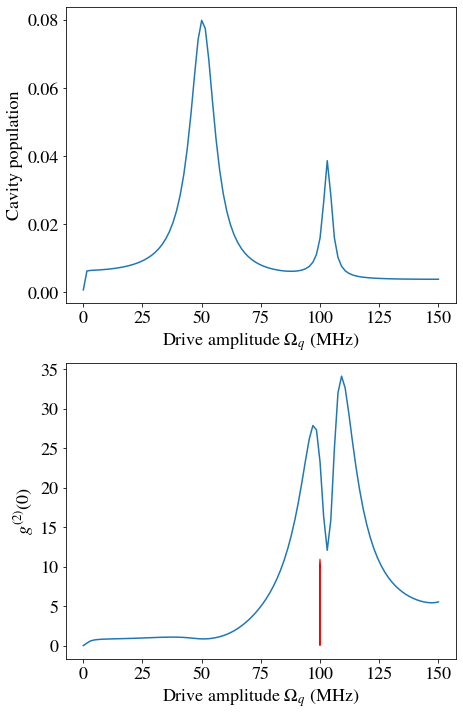

In [ ]:
fig, axis = plt.subplots(nrows=2, figsize=(7,12))

ax = axis[0]
ax.plot(Omega_q_grid,naarray)
ax.set_ylabel('Cavity population')
ax.set_xlabel('Drive amplitude $\Omega_q$ (MHz)')


ax = axis[1]
ax.plot(Omega_q_grid,g2array)
ax.set_ylabel('$g^{(2)} (0)$')
ax.set_xlabel('Drive amplitude $\Omega_q$ (MHz)')

ax.arrow(Delta_a, 0, 0, 10, width=0.01, head_width=0.5, head_length=1, color='red')
plt.show()